In [1]:
import pandas as pd 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np
import statsmodels
import statsmodels.api as sm
%matplotlib inline

app_dir = '/Users/nikhilvs/repos/nyu/covid-19'

In [2]:
df = pd.read_csv(os.path.join(app_dir, 'data/staging/unified.csv'))
country_df = df[df['country_region'] == 'Spain']

In [3]:
list(df.columns)

['country_region',
 'date',
 'retail_and_recreation_percent_change_from_baseline',
 'grocery_and_pharmacy_percent_change_from_baseline',
 'parks_percent_change_from_baseline',
 'transit_stations_percent_change_from_baseline',
 'workplaces_percent_change_from_baseline',
 'residential_percent_change_from_baseline',
 'C1_School closing',
 'C2_Workplace closing',
 'C3_Cancel public events',
 'C4_Restrictions on gatherings',
 'C5_Close public transport',
 'C6_Stay at home requirements',
 'C7_Restrictions on internal movement',
 'C8_International travel controls',
 'E1_Income support',
 'E2_Debt/contract relief',
 'H1_Public information campaigns',
 'H2_Testing policy',
 'H3_Contact tracing',
 'StringencyIndex',
 'cases',
 'cases_lag_1',
 'cases_lag_2',
 'cases_lag_3',
 'cases_lag_4',
 'cases_lag_5',
 'cases_lag_6',
 'cases_lag_7',
 'cases_lag_8',
 'cases_lag_9',
 'cases_lag_10',
 'cases_lag_11',
 'cases_lag_12',
 'cases_lag_13',
 'cases_lag_14',
 'cases_lag_15',
 'cases_lag_16',
 'cases_lag

In [4]:
TRAIN_COLUMNS = [
    # 'country_region',
    # 'date',
    'retail_and_recreation_percent_change_from_baseline',
    'grocery_and_pharmacy_percent_change_from_baseline',
    'parks_percent_change_from_baseline',
    'transit_stations_percent_change_from_baseline',
    'workplaces_percent_change_from_baseline',
    'residential_percent_change_from_baseline',
    'C1_School closing',
    'C2_Workplace closing',
    'C3_Cancel public events',
    'C4_Restrictions on gatherings',
    'C5_Close public transport',
    'C6_Stay at home requirements',
    'C7_Restrictions on internal movement',
    'C8_International travel controls',
    'E1_Income support',
    'E2_Debt/contract relief',
    'H1_Public information campaigns',
    'H2_Testing policy',
    'H3_Contact tracing',
    'StringencyIndex',
    'population_density',
    # 'cases_lag_1',
    # 'cases_lag_2',
    # 'cases_lag_3',
    # 'cases_lag_4',
    # 'cases_lag_5',
    # 'cases_lag_6',
    'cases_lag_7'
    # 'cases_lag_8',
    # 'cases_lag_9',
    # 'cases_lag_10'
    # 'date+1_pred',
    # 'date+2_pred',
    # 'date+3_pred',
    # 'date+4_pred',
    # 'date+5_pred',
    # 'date+6_pred',
    # 'date+7_pred',
    # 'date+8_pred',
    # 'date+1_linf',
    # 'date+2_linf',
    # 'date+3_linf',
    # 'date+4_linf',
    # 'date+5_linf',
    # 'date+6_linf',
    # 'date+7_linf',
    # 'date+8_linf',
    # 'date+1_lsup',
    # 'date+2_lsup',
    # 'date+3_lsup',
    # 'date+4_lsup',
    # 'date+5_lsup',
    # 'date+6_lsup',
    # 'date+7_lsup',
    # 'date+8_lsup'
]

TARGET_COLUMNS = [
    'cases'
]

COUNTRIES = [
    'United States', 
    'India', 
    'Italy', 
    'Canada', 
    'Spain', 
    'France', 
    'United Kingdom',
    'Iraq',
    'Japan',
    'Turkey',
    'Germany',
    'Brazil'
]

In [25]:
df[df['country_region'] == 'United States']

,country_region,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,C1_School closing,C2_Workplace closing,...,date+1_lsup,date+2_lsup,date+3_lsup,date+4_lsup,date+5_lsup,date+6_lsup,date+7_lsup,date+8_lsup,date+9_lsup,date+10_lsup
824,United States,2020-02-15,6.073507,2.225115,5.158882,1.633614,0.360260,-0.191041,0.0,0.0,...,1.471680e+01,1.573358e+01,1.663521e+01,1.747724e+01,1.828119e+01,1.905809e+01,1.981449e+01,2.055466e+01,2.128158e+01,2.199740e+01
825,United States,2020-02-16,7.348642,2.333067,5.500399,1.421326,0.386581,-0.217652,0.0,0.0,...,1.467697e+01,1.566631e+01,1.654339e+01,1.736269e+01,1.814527e+01,1.890193e+01,1.963905e+01,2.036079e+01,2.107003e+01,2.176888e+01
826,United States,2020-02-17,3.351574,-0.296495,6.552217,0.668455,-17.336910,2.294349,0.0,0.0,...,1.459488e+01,1.553989e+01,1.639057e+01,1.719752e+01,1.797977e+01,1.874679e+01,1.950407e+01,2.025506e+01,2.100208e+01,2.174678e+01
827,United States,2020-02-18,-0.170090,-1.094775,1.335495,0.843243,-0.005405,0.455856,0.0,0.0,...,1.451972e+01,1.541157e+01,1.621706e+01,1.698472e+01,1.773262e+01,1.846963e+01,1.920082e+01,1.992933e+01,2.065723e+01,2.138595e+01
828,United States,2020-02-19,1.836030,0.497663,1.990651,0.935994,0.869831,0.102481,0.0,0.0,...,1.445268e+01,1.529552e+01,1.605763e+01,1.678594e+01,1.749779e+01,1.820161e+01,1.890216e+01,1.960234e+01,2.030408e+01,2.100864e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904,United States,2020-05-05,-8.417465,1.221512,4.386226,-7.482428,-33.689386,6.930067,3.0,3.0,...,1.231230e+06,1.259035e+06,1.287703e+06,1.317093e+06,1.347114e+06,1.377706e+06,1.408821e+06,1.440423e+06,1.472482e+06,1.504972e+06
905,United States,2020-05-06,-9.039446,0.488628,5.067520,-7.391258,-33.651741,6.931770,3.0,3.0,...,1.257138e+06,1.285867e+06,1.315459e+06,1.345772e+06,1.376717e+06,1.408232e+06,1.440271e+06,1.472796e+06,1.505777e+06,1.539189e+06
906,United States,2020-05-07,-9.466382,1.257560,8.353967,-7.186411,-33.568837,6.886873,3.0,3.0,...,1.287751e+06,1.319440e+06,1.352006e+06,1.385300e+06,1.419233e+06,1.453741e+06,1.488777e+06,1.524304e+06,1.560291e+06,1.596714e+06
907,United States,2020-05-08,-12.871316,0.065780,3.104960,-8.633357,-33.153487,7.473400,3.0,3.0,...,1.313463e+06,1.343894e+06,1.375184e+06,1.407194e+06,1.439835e+06,1.473044e+06,1.506776e+06,1.540993e+06,1.575665e+06,1.610768e+06


In [5]:
# for SHIFT_IMPACT_DAYS in list(range(1, 10)):
SHIFT_IMPACT_DAYS = 8
all_countries_df = None

for country in COUNTRIES:
    country_shifted_df = df[df['country_region'] == country].copy()

    SHIFT_COL_TARGET = 'cases_' + str(SHIFT_IMPACT_DAYS)
    country_shifted_df[SHIFT_COL_TARGET] = country_shifted_df['cases'].shift(-SHIFT_IMPACT_DAYS)

    for lag in range(1, 11):
        SHIFT_COL = f'cases_lag_{lag}_' + str(SHIFT_IMPACT_DAYS)
        country_shifted_df[SHIFT_COL] = country_shifted_df[f'cases_lag_{lag}'].shift(-SHIFT_IMPACT_DAYS)

    country_shifted_df = country_shifted_df.dropna()
    if all_countries_df is None:
        all_countries_df = pd.DataFrame(columns = country_shifted_df.columns)
    
    all_countries_df = all_countries_df.append(country_shifted_df)



In [11]:
# fit polynomial regressor

SIGNIFICANT_TRAIN_COLUMNS = TRAIN_COLUMNS.copy()
# SIGNIFICANT_TRAIN_COLUMNS.remove('grocery_and_pharmacy_percent_change_from_baseline')
# SIGNIFICANT_TRAIN_COLUMNS.remove('H3_Contact tracing')
# SIGNIFICANT_TRAIN_COLUMNS.remove('C8_International travel controls')
# SIGNIFICANT_TRAIN_COLUMNS.remove('population_density')
# SIGNIFICANT_TRAIN_COLUMNS.remove('C2_Workplace closing')
# SIGNIFICANT_TRAIN_COLUMNS.remove('residential_percent_change_from_baseline')

train_subset = all_countries_df[all_countries_df['date'] <= '2020-04-24']
test_subset = all_countries_df[all_countries_df['date'] > '2020-04-24']
val_subset = test_subset[test_subset['date'] <= '2020-04-30']
test_subset = test_subset[test_subset['date'] > '2020-04-30']

X_train = train_subset[SIGNIFICANT_TRAIN_COLUMNS]
y_train = train_subset[SHIFT_COL_TARGET]
X_val = val_subset[SIGNIFICANT_TRAIN_COLUMNS]
y_val = val_subset[SHIFT_COL_TARGET]
X_test = test_subset[SIGNIFICANT_TRAIN_COLUMNS]
y_test = test_subset[SHIFT_COL_TARGET]

degrees = [2]

best_degree = 0
best_mse = 1e14
best_l2_reg = 0
DEG_MSES = []
for degree in degrees:
    poly = PolynomialFeatures(degree)

    X_train_poly = poly.fit_transform(X_train)
    scaler = preprocessing.StandardScaler().fit(X_train_poly)

    X_train_poly = scaler.transform(X_train_poly)
    X_val_poly = scaler.transform(poly.transform(X_val))
    X_test_poly = scaler.transform(poly.transform(X_test))

    # L2_REGS = [0.1, 0.5, 0.75, 0.8, 0.82, 0.85, 0.87, 0.9, 0.93, 0.95, 1, 1.05, 2, 3, 3.5, 4, 4.5, 5, 6, 7, 10, 20]
    L2_REGS = [1,  5, 8, 10, 13, 13.5, 14.4003, 15, 20, 30, 50, 100, 200, 500]
    # L2_REGS = [14.423, 14.425, 14.427, 14.429, 14.43, 14.435, 14.437, 14.439]
    # L2_REGS = [14.39999, 14.4, 14.4001, 14.4002, 14.4003]
    # L2_REGS = [20, 40, 60, 80, 100, 120, 150]
    VAL_MSES = []
    VAL_R2 = []
    for l2_reg in L2_REGS:
        reg = Ridge(alpha = l2_reg).fit(X_train_poly, y_train)
        val_pred = reg.predict(X_val_poly)
        val_mse = mean_squared_error(y_val, val_pred)
        val_r2 = r2_score(y_val, val_pred)
        VAL_MSES.append(val_mse)
        VAL_R2.append(val_r2)

        if val_mse < best_mse:
            best_mse = val_mse
            best_degree = degree
            best_l2_reg = l2_reg
    
    DEG_MSES.append(VAL_MSES)


In [12]:
print(best_degree, best_l2_reg, best_mse)

2 15 509765470.07480145


In [13]:
X_train_poly.shape

(743, 276)

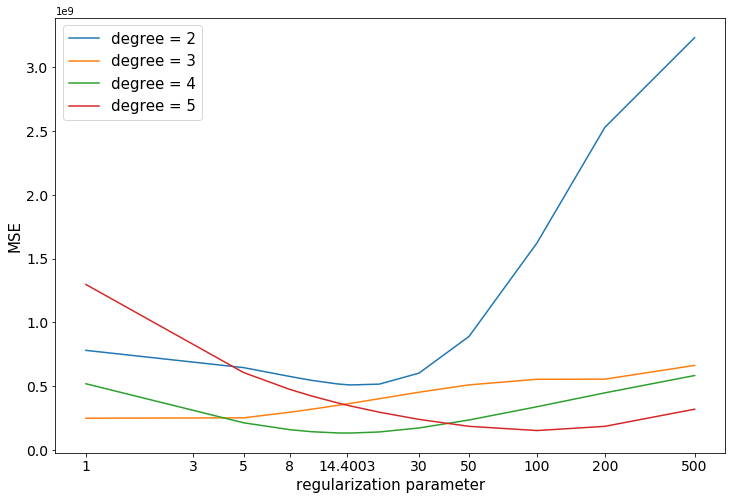

In [8]:
plt.figure(figsize = (12, 8))
# plt.plot(L2_REGS, VAL_MSES)
# plt.plot(L2_REGS, VAL_MSES)

X_TICKS = [1, 3, 5, 8, 14.4003, 30, 50, 100, 200, 500]
for degree in degrees:
    plt.plot(np.log10(L2_REGS), DEG_MSES[degree - 2], label = f'degree = {degree}')
plt.legend(prop={'size': 15})
plt.xlabel('regularization parameter', fontsize = 15)
plt.ylabel('MSE', fontsize = 15)
plt.xticks(ticks = np.log10(X_TICKS), labels = X_TICKS, fontsize = 14)
plt.yticks(fontsize = 14)
plt.savefig(os.path.join(app_dir, 'plots', 'polyreg_tuning.png'))

In [50]:
# significance testing

X_train_const = sm.add_constant(X_train_poly)
ols_regressor = sm.OLS(endog = y_train, exog = np.asarray(X_train_const)).fit()
ridge_regressor = sm.OLS(endog = y_train, exog = np.asarray(X_train_const)).fit_regularized(
    method = 'elastic_net',
    alpha = 10,
    L1_wt = 0
)

In [20]:
train_val_subset = train_subset.append(val_subset)
all_subsets = all_countries_df

poly = PolynomialFeatures(4)

X_train_val = train_val_subset[SIGNIFICANT_TRAIN_COLUMNS]
y_train_val = train_val_subset[SHIFT_COL_TARGET]
X_all = all_subsets[SIGNIFICANT_TRAIN_COLUMNS]
y_all = all_subsets[SHIFT_COL_TARGET]

X_train_val_poly = poly.fit_transform(X_train_val)
scaler = preprocessing.StandardScaler().fit(X_train_val_poly)

X_train_val_poly = scaler.transform(X_train_val_poly)
X_all_poly = scaler.transform(poly.transform(X_all))

reg = Ridge(alpha = 14.4003).fit(X_train_val_poly, y_train_val)
# train_val_pred = reg.predict(X_train_val_poly)
# val_mse = mean_squared_error(y_val, train_val_pred)
# train_pred = reg.predict(X_train_poly)
# val_pred = reg.predict(X_val_poly)

all_countries = all_subsets['country_region']
all_dates = all_subsets['date']
all_preds = reg.predict(X_all_poly)
all_gt = y_all
# all_countries = train_subset['country_region'].append(val_subset['country_region'])
# all_preds = np.append(train_pred, val_pred)
# all_gt = y_train.append(y_val)

test_countries = test_subset['country_region']
countries_with_preds = pd.DataFrame(data = {
    'country' : all_countries,
    'date': all_dates,
    'polyreg_preds' : all_preds,
    'gt': all_gt
})


In [21]:
countries_with_preds.to_csv(os.path.join(app_dir, 'data/staging', 'polyreg_preds.csv'), index = False)

In [22]:
countries_with_preds[countries_with_preds['country'] == 'United Statesb']

,country,date,polyreg_preds,gt
824,United States,2020-02-15,1.768169e+02,15.0
825,United States,2020-02-16,1.615348e+02,51.0
826,United States,2020-02-17,9.759291e+00,51.0
827,United States,2020-02-18,1.778869e+02,57.0
828,United States,2020-02-19,1.995914e+02,58.0
...,...,...,...,...
896,United States,2020-04-27,1.201110e+06,1204351.0
897,United States,2020-04-28,1.231006e+06,1229331.0
898,United States,2020-04-29,1.255659e+06,1257023.0
899,United States,2020-04-30,1.283220e+06,1283929.0


In [24]:
all_countries_df[all_countries_df['country_region'] == 'United States']

,country_region,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,C1_School closing,C2_Workplace closing,...,cases_lag_1_8,cases_lag_2_8,cases_lag_3_8,cases_lag_4_8,cases_lag_5_8,cases_lag_6_8,cases_lag_7_8,cases_lag_8_8,cases_lag_9_8,cases_lag_10_8
824,United States,2020-02-15,6.073507,2.225115,5.158882,1.633614,0.360260,-0.191041,0.0,0.0,...,15.0,15.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0
825,United States,2020-02-16,7.348642,2.333067,5.500399,1.421326,0.386581,-0.217652,0.0,0.0,...,15.0,15.0,15.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0
826,United States,2020-02-17,3.351574,-0.296495,6.552217,0.668455,-17.336910,2.294349,0.0,0.0,...,51.0,15.0,15.0,15.0,13.0,13.0,13.0,13.0,13.0,13.0
827,United States,2020-02-18,-0.170090,-1.094775,1.335495,0.843243,-0.005405,0.455856,0.0,0.0,...,51.0,51.0,15.0,15.0,15.0,13.0,13.0,13.0,13.0,13.0
828,United States,2020-02-19,1.836030,0.497663,1.990651,0.935994,0.869831,0.102481,0.0,0.0,...,57.0,51.0,51.0,15.0,15.0,15.0,13.0,13.0,13.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896,United States,2020-04-27,-11.728571,-3.372857,1.981429,-10.093929,-34.606429,7.289286,3.0,3.0,...,1180375.0,1158040.0,1132539.0,1103461.0,1069424.0,1039909.0,1012582.0,988197.0,965785.0,938154.0
897,United States,2020-04-28,-11.582270,-2.208865,4.684397,-8.724823,-36.568085,4.718440,3.0,3.0,...,1204351.0,1180375.0,1158040.0,1132539.0,1103461.0,1069424.0,1039909.0,1012582.0,988197.0,965785.0
898,United States,2020-04-29,-11.447788,-1.941593,1.966726,-9.041416,-36.765310,7.644956,3.0,3.0,...,1229331.0,1204351.0,1180375.0,1158040.0,1132539.0,1103461.0,1069424.0,1039909.0,1012582.0,988197.0
899,United States,2020-04-30,-11.858360,-1.351438,0.797302,-9.163294,-36.568335,7.785588,3.0,3.0,...,1257023.0,1229331.0,1204351.0,1180375.0,1158040.0,1132539.0,1103461.0,1069424.0,1039909.0,1012582.0


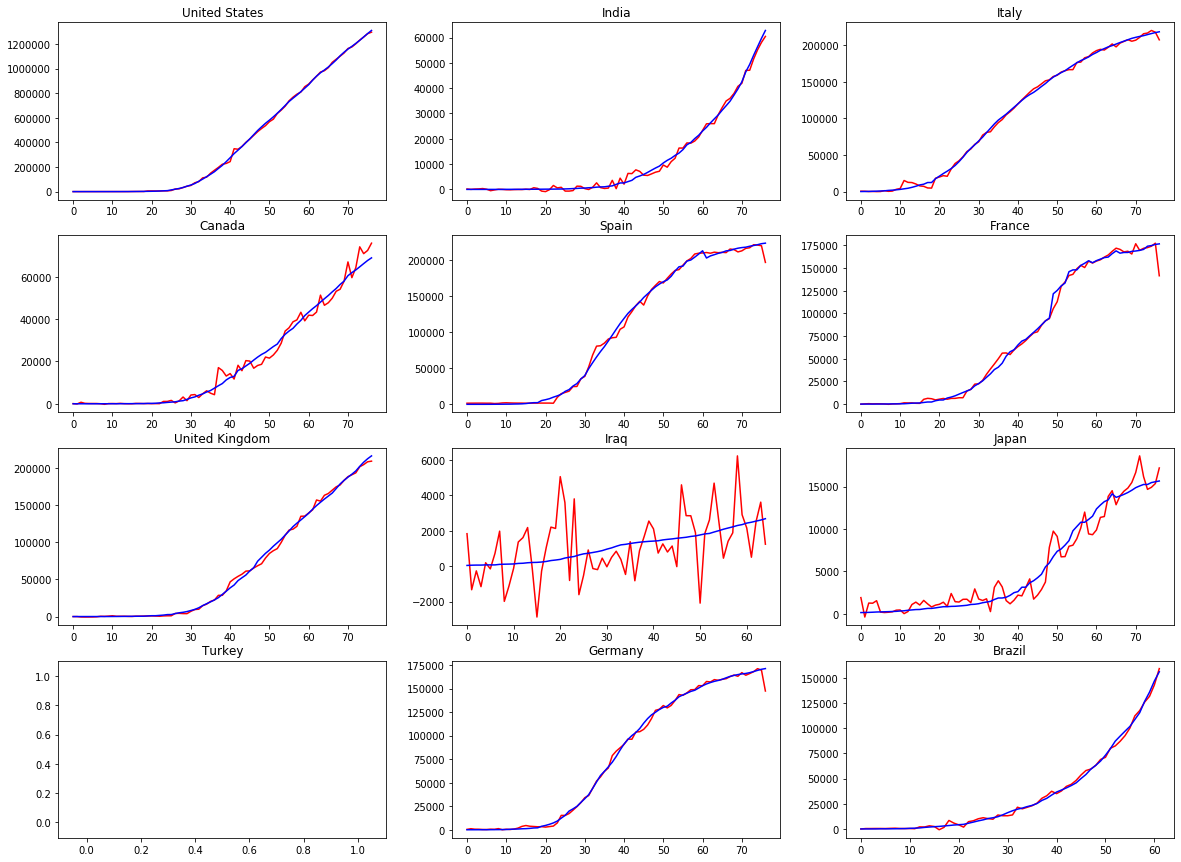

In [16]:
fig, (
    (ax11, ax12, ax13), 
    (ax21, ax22, ax23),
    (ax31, ax32, ax33),
    (ax41, ax42, ax43)
) = plt.subplots(4, 3)
# fig.suptitle('Sharing x per column, y per row')

fig.set_figwidth(20)
fig.set_figheight(15)
axes = [ax11, ax12, ax13, ax21, ax22, ax23, ax31, ax32, ax33, ax41, ax42, ax43]
countries = COUNTRIES

for country, ax in zip(countries, axes):
    country_preds = countries_with_preds[countries_with_preds['country'] == country]
    dates = np.arange(country_preds.shape[0])
    ax.plot(dates, country_preds['preds'], 'r-')
    ax.plot(dates, country_preds['gt'], 'b-')
    ax.set_title(country)

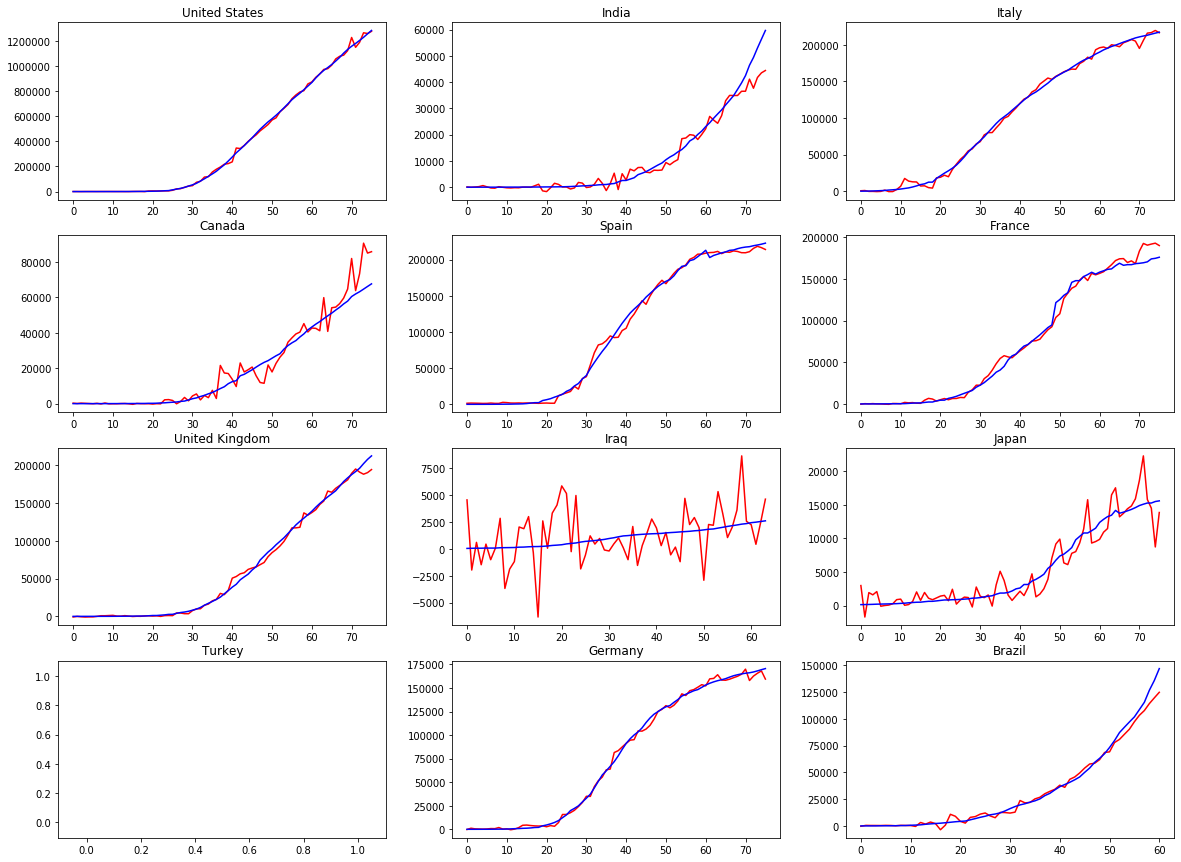

In [52]:
fig, (
    (ax11, ax12, ax13), 
    (ax21, ax22, ax23),
    (ax31, ax32, ax33),
    (ax41, ax42, ax43)
) = plt.subplots(4, 3)
# fig.suptitle('Sharing x per column, y per row')

fig.set_figwidth(20)
fig.set_figheight(15)
axes = [ax11, ax12, ax13, ax21, ax22, ax23, ax31, ax32, ax33, ax41, ax42, ax43]
countries = COUNTRIES

for country, ax in zip(countries, axes):
    country_preds = countries_with_preds[countries_with_preds['country'] == country]
    dates = np.arange(country_preds.shape[0])
    ax.plot(dates, country_preds['preds'], 'r-')
    ax.plot(dates, country_preds['gt'], 'b-')
    ax.set_title(country)